In [1]:
!python -m spacy download en_core_web_sm --quiet

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [2]:
import pandas as pd
import numpy as np
import time
import re
import string
import warnings
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import time
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from spacy.tokenizer import Tokenizer
import gensim
from gensim import corpora
import json
%matplotlib inline


# supress warnings
warnings.filterwarnings("ignore")

In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We will load in our scraped tweets from our [web scraping notebook](https://github.com/tarrantcarter/Final_Capstone/blob/main/Modern_Motivation_Web_Scrape.ipynb). The json file can be downloaded from [here](https://drive.google.com/file/d/1rcAy7gabh7NwIXTjF_mhEcvyaaTzc_C-/view?usp=sharing).

In [5]:
# load in scraped tweets from 
tweets = pd.read_json(
    "/content/drive/MyDrive/Data/NLP_Capstone/motivational_tweets.json",
)

In [6]:
tweets.head()

,index,url,date,content,renderedContent,id,user,outlinks,tcooutlinks,replyCount,retweetCount,likeCount,quoteCount,conversationId,lang,source,sourceUrl,sourceLabel,media,retweetedTweet,quotedTweet,mentionedUsers
0,0,https://twitter.com/LewisHowes/status/13515332...,2021-01-19 14:13:23,My guest @MrJamesNestor has spent years in lab...,My guest @MrJamesNestor has spent years in lab...,1351533215459258369,"{'username': 'LewisHowes', 'displayname': 'Lew...",[https://link.chtbl.com/1060-tw],[https://t.co/xMjUvSkJtD],3,4,25,1,1351533215459258369,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,[{'thumbnailUrl': 'https://pbs.twimg.com/ext_t...,NaN,None,"[{'username': 'MrJamesNestor', 'displayname': ..."
1,1,https://twitter.com/LewisHowes/status/13515234...,2021-01-19 13:34:33,"@EDGcoach Thanks, I appreciate it! ❤","@EDGcoach Thanks, I appreciate it! ❤",1351523443234263045,"{'username': 'LewisHowes', 'displayname': 'Lew...",[],[],1,0,1,0,1351168601496150023,en,"<a href=""http://www.zendesk.com"" rel=""nofollow...",http://www.zendesk.com,Zendesk,None,NaN,None,"[{'username': 'EDGcoach', 'displayname': 'Empo..."
2,2,https://twitter.com/LewisHowes/status/13514478...,2021-01-19 08:34:12,@imchrisjordan 💯,@imchrisjordan 💯,1351447858629799940,"{'username': 'LewisHowes', 'displayname': 'Lew...",[],[],0,0,0,0,1351051353116831745,und,"<a href=""http://www.zendesk.com"" rel=""nofollow...",http://www.zendesk.com,Zendesk,None,NaN,None,"[{'username': 'imchrisjordan', 'displayname': ..."
3,3,https://twitter.com/LewisHowes/status/13514317...,2021-01-19 07:30:13,@MKenkadze Glad you loved it!,@MKenkadze Glad you loved it!,1351431756688347137,"{'username': 'LewisHowes', 'displayname': 'Lew...",[],[],0,0,1,0,1350102468126883842,en,"<a href=""http://www.zendesk.com"" rel=""nofollow...",http://www.zendesk.com,Zendesk,None,NaN,None,"[{'username': 'MKenkadze', 'displayname': 'Mar..."
4,4,https://twitter.com/LewisHowes/status/13514300...,2021-01-19 07:23:25,@sueizzo My pleasure! ❤,@sueizzo My pleasure! ❤,1351430042384003072,"{'username': 'LewisHowes', 'displayname': 'Lew...",[],[],0,0,0,0,1351040232003612673,en,"<a href=""http://www.zendesk.com"" rel=""nofollow...",http://www.zendesk.com,Zendesk,None,NaN,None,"[{'username': 'sueizzo', 'displayname': 'Sue I..."


In [7]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 977611 entries, 0 to 977610
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   index            977611 non-null  int64         
 1   url              977611 non-null  object        
 2   date             977611 non-null  datetime64[ns]
 3   content          977611 non-null  object        
 4   renderedContent  977611 non-null  object        
 5   id               977611 non-null  int64         
 6   user             977611 non-null  object        
 7   outlinks         977611 non-null  object        
 8   tcooutlinks      977611 non-null  object        
 9   replyCount       977611 non-null  int64         
 10  retweetCount     977611 non-null  int64         
 11  likeCount        977611 non-null  int64         
 12  quoteCount       977611 non-null  int64         
 13  conversationId   977611 non-null  int64         
 14  lang             977

In [8]:
tweets.applymap(type)

,index,url,date,content,renderedContent,id,user,outlinks,tcooutlinks,replyCount,retweetCount,likeCount,quoteCount,conversationId,lang,source,sourceUrl,sourceLabel,media,retweetedTweet,quotedTweet,mentionedUsers
0,<class 'int'>,<class 'str'>,<class 'pandas._libs.tslibs.timestamps.Timesta...,<class 'str'>,<class 'str'>,<class 'int'>,<class 'dict'>,<class 'list'>,<class 'list'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'list'>,<class 'float'>,<class 'NoneType'>,<class 'list'>
1,<class 'int'>,<class 'str'>,<class 'pandas._libs.tslibs.timestamps.Timesta...,<class 'str'>,<class 'str'>,<class 'int'>,<class 'dict'>,<class 'list'>,<class 'list'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'NoneType'>,<class 'float'>,<class 'NoneType'>,<class 'list'>
2,<class 'int'>,<class 'str'>,<class 'pandas._libs.tslibs.timestamps.Timesta...,<class 'str'>,<class 'str'>,<class 'int'>,<class 'dict'>,<class 'list'>,<class 'list'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'NoneType'>,<class 'float'>,<class 'NoneType'>,<class 'list'>
3,<class 'int'>,<class 'str'>,<class 'pandas._libs.tslibs.timestamps.Timesta...,<class 'str'>,<class 'str'>,<class 'int'>,<class 'dict'>,<class 'list'>,<class 'list'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'NoneType'>,<class 'float'>,<class 'NoneType'>,<class 'list'>
4,<class 'int'>,<class 'str'>,<class 'pandas._libs.tslibs.timestamps.Timesta...,<class 'str'>,<class 'str'>,<class 'int'>,<class 'dict'>,<class 'list'>,<class 'list'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'NoneType'>,<class 'float'>,<class 'NoneType'>,<class 'list'>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977606,<class 'int'>,<class 'str'>,<class 'pandas._libs.tslibs.timestamps.Timesta...,<class 'str'>,<class 'str'>,<class 'int'>,<class 'dict'>,<class 'list'>,<class 'list'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'NoneType'>,<class 'float'>,<class 'NoneType'>,<class 'NoneType'>
977607,<class 'int'>,<class 'str'>,<class 'pandas._libs.tslibs.timestamps.Timesta...,<class 'str'>,<class 'str'>,<class 'int'>,<class 'dict'>,<class 'list'>,<class 'list'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'NoneType'>,<class 'float'>,<class 'NoneType'>,<class 'NoneType'>
977608,<class 'int'>,<class 'str'>,<class 'pandas._libs.tslibs.timestamps.Timesta...,<class 'str'>,<class 'str'>,<class 'int'>,<class 'dict'>,<class 'list'>,<class 'list'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'NoneType'>,<class 'float'>,<class 'NoneType'>,<class 'NoneType'>
977609,<class 'int'>,<class 'str'>,<class 'pandas._libs.tslibs.timestamps.Timesta...,<class 'str'>,<class 'str'>,<class 'int'>,<class 'dict'>,<class 'list'>,<class 'list'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'NoneType'>,<class 'float'>,<class 'NoneType'>,<class 'NoneType'>


The only columns we need for our analysis are the content column ('content'), a column that identifies the author of the tweet ('user'), the date ('date'), and the language column ('lang'). Let's remove all unnecessary columns. 

In [9]:
#remove unnecessary columns
tweets2 = tweets[['date','content','user','lang']]

tweets2.head()

,date,content,user,lang
0,2021-01-19 14:13:23,My guest @MrJamesNestor has spent years in lab...,"{'username': 'LewisHowes', 'displayname': 'Lew...",en
1,2021-01-19 13:34:33,"@EDGcoach Thanks, I appreciate it! ❤","{'username': 'LewisHowes', 'displayname': 'Lew...",en
2,2021-01-19 08:34:12,@imchrisjordan 💯,"{'username': 'LewisHowes', 'displayname': 'Lew...",und
3,2021-01-19 07:30:13,@MKenkadze Glad you loved it!,"{'username': 'LewisHowes', 'displayname': 'Lew...",en
4,2021-01-19 07:23:25,@sueizzo My pleasure! ❤,"{'username': 'LewisHowes', 'displayname': 'Lew...",en


In [10]:
# extend max col width so all the text can be seen
pd.set_option("display.max_colwidth", None)

tweets2["content"][:20]

0     My guest @MrJamesNestor has spent years in laboratories and ancient burial sites, working with researchers to figure out that a lot of us may not be breathing correctly. And he’s learned how to fix it. 👃\n\nLearn more from @MrJamesNestor at https://t.co/xMjUvSkJtD https://t.co/YZHZAKaUge
1                                                                                                                                                                                                                                                                 @EDGcoach Thanks, I appreciate it! ❤
2                                                                                                                                                                                                                                                                                     @imchrisjordan 💯
3                                                                                                                  

In [11]:
tweets2["content"][-20:]

977591                                                                   If the facts don't fit the theory, change the facts. Albert Einstein #quotes
977592               When we stop opposing reality, action becomes simple, fluid, kind, and fearless. Byron Katie #quote http://t.co/Pi92xkZl #quotes
977593              I believe that a simple and unassuming manner of life is best for everyone, best both for the body and the mind.\nAlbert Einstein
977594                                                               Never deprive someone of hope; it might be all they have.\nH. Jackson Brown, Jr.
977595                                                      All I can do is leave it in God's hands and hope that my fans feel where I'm coming from.
977596               Make big plans; aim high in hope and work, remembering that a noble, logical diagram once recorded will not die.\nDaniel Burnham
977597                                                     If we don't change, we don't grow. If we 

After further inspection of the content column, tweets that start with @ are specific tweets to other user. These tweets will be removed because we want motivational tweets that are geared towards a general audience. We also have to remove tweets that have hyperlinks since those tweets are more calls to action and not general motivational advise. Hashtags and retweets will also be removed in this step. 

Additionally we will remove text that contains more than one character outside of the latin alphabet. This will include emojis and emoticons by taking advantage of the ord() function. This step won't completely remove all non-english tweets, but it will deal with emojis and emoticons. Languages like French, German, and Spanish use a latin alphabet. We will remove the rest of the non-english text by filtering the 'lang' column by 'en'. 

We will attempt to clean our dataset as much as possible in the following step. We wil create one function to accomplish this task as well as several helper functions. 

In [12]:
# convert any non-text to text in the content column
tweets2["content"] = tweets2["content"].map(str)

In [13]:
# helper function to remove hastags and retweets
def remove_hashtags_retweets(text):
    text = re.sub("#\S+", "", str(text))
    text = re.sub(r"RT.+", "", str(text))
    return text

# helper function that returns True if no more than one character is non-latin
def is_latin_alphabet(string):
    non_ascii = 0

    for character in string:
        if ord(character) > 127:
            non_ascii += 1

    if non_ascii > 1:
        return False
    else:
        return True

# remove special characters, profanity, web links, hashtags, retweets, emojis, non-english text
def tweet_cleaner(df,text='content',lang='lang'):
  # make a copy of dataframe
  df2 = df.copy()
  # remove all tweets that contain @
  df3 = df2[~(df2[text].str.contains("@"))]
  # drop rows containing http links
  df4 = df3[~(df3[text].str.contains("http"))]
  # remove line breaks
  df4[text] = df4[text].str.replace("\n", " ")
  # change non-latin apostrophe to latin counterpart
  df4[text] = df4[text].str.replace("’", "'")
  # remove ampersand text 
  df4[text] = df4[text].str.replace("amp;", "")
  # remove ampersand text 
  df4[text] = df4[text].str.replace("amp", "")
  # filter out profanity
  df5 = df4[~(df4[text].str.contains('fuck')|
                  df4[text].str.contains('shit')|
                  df4[text].str.contains('bitch')|
                  df4[text].str.contains('asshole')|
                  df4[text].str.contains('bastard')|
                  df4[text].str.contains('damn'))]
  # remove hastage and retweets
  no_rt_hashtags = [remove_hashtags_retweets(text) for text in df5[text]]

  df6 = df5.copy()
  df6[text] = no_rt_hashtags
  # make a list with emoji less text or append with none
  latin_emojiless_text = []

  for words in df6[text]:
      if is_latin_alphabet(words) == True:
          latin_emojiless_text.append(text)
      else:
          latin_emojiless_text.append(None)

  df7 = df6.copy()
  # add emojiless text to df
  df7[text] = latin_emojiless_text
  # remove non-english tweets
  cleaned_df = df6[df6[lang] == "en"]
  return cleaned_df



In [14]:
tweets3 = tweet_cleaner(tweets2)

tweets3.head()

,date,content,user,lang
44,2021-01-17 22:13:17,Know this. Everything is happening for a reason and in your favor for the betterment of your future. The pain you feel now will help later if you: 1. Look at what's not serving you 2. Listen to your intuition 3. Learn the meaning behind it 4. Let go of limits that hold you back,"{'username': 'LewisHowes', 'displayname': 'Lewis Howes', 'id': 14777649, 'description': 'NY Times Bestselling author. Top Podcast with 300 million downloads. Former pro football current @usath text me here and stay connected! 📲 614-350-3960', 'rawDescription': 'NY Times Bestselling author. Top Podcast with 300 million downloads. Former pro football current @usath text me here and stay connected! 📲 614-350-3960', 'descriptionUrls': [], 'verified': True, 'created': '2008-05-14T19:54:36+00:00', 'followersCount': 193467, 'friendsCount': 34018, 'statusesCount': 132010, 'favouritesCount': 152172, 'listedCount': 5431, 'mediaCount': 4231, 'location': 'Ohio boy in NYC and LA', 'protected': False, 'linkUrl': 'http://lewishowes.com', 'linkTcourl': 'https://t.co/hLkL1LJ3d4', 'profileImageUrl': 'https://pbs.twimg.com/profile_images/904400279113687041/bSzT-5v4_normal.jpg', 'profileBannerUrl': 'https://pbs.twimg.com/profile_banners/14777649/1600464122', 'url': 'https://twitter.com/LewisHowes'}",en
61,2021-01-15 15:28:06,Protect your inner peace at all costs. Create daily practices and communicate boundaries to make sure the stress and drama of others doesn't consume you. You don't need to be someone else's emotional punching bag. Your energy and happiness is too important. Protect your peace!,"{'username': 'LewisHowes', 'displayname': 'Lewis Howes', 'id': 14777649, 'description': 'NY Times Bestselling author. Top Podcast with 300 million downloads. Former pro football current @usath text me here and stay connected! 📲 614-350-3960', 'rawDescription': 'NY Times Bestselling author. Top Podcast with 300 million downloads. Former pro football current @usath text me here and stay connected! 📲 614-350-3960', 'descriptionUrls': [], 'verified': True, 'created': '2008-05-14T19:54:36+00:00', 'followersCount': 193467, 'friendsCount': 34018, 'statusesCount': 132010, 'favouritesCount': 152172, 'listedCount': 5431, 'mediaCount': 4231, 'location': 'Ohio boy in NYC and LA', 'protected': False, 'linkUrl': 'http://lewishowes.com', 'linkTcourl': 'https://t.co/hLkL1LJ3d4', 'profileImageUrl': 'https://pbs.twimg.com/profile_images/904400279113687041/bSzT-5v4_normal.jpg', 'profileBannerUrl': 'https://pbs.twimg.com/profile_banners/14777649/1600464122', 'url': 'https://twitter.com/LewisHowes'}",en
108,2021-01-12 16:40:46,You are stronger than you think. The painful moments that hurt you in the past were meant for you. They broke you down so you could become stronger than ever before. I know it was hard. I know you wouldn't wish it on anyone else. But I also know you wouldn't change a thing!,"{'username': 'LewisHowes', 'displayname': 'Lewis Howes', 'id': 14777649, 'description': 'NY Times Bestselling author. Top Podcast with 300 million downloads. Former pro football current @usath text me here and stay connected! 📲 614-350-3960', 'rawDescription': 'NY Times Bestselling author. Top Podcast with 300 million downloads. Former pro football current @usath text me here and stay connected! 📲 614-350-3960', 'descriptionUrls': [], 'verified': True, 'created': '2008-05-14T19:54:36+00:00', 'followersCount': 193467, 'friendsCount': 34018, 'statusesCount': 132010, 'favouritesCount': 152172, 'listedCount': 5431, 'mediaCount': 4231, 'location': 'Ohio boy in NYC and LA', 'protected': False, 'linkUrl': 'http://lewishowes.com', 'linkTcourl': 'https://t.co/hLkL1LJ3d4', 'profileImageUrl': 'https://pbs.twimg.com/profile_images/904400279113687041/bSzT-5v4_normal.jpg', 'profileBannerUrl': 'https://pbs.twimg.com/profile_banners/14777649/1600464122', 'url': 'https://twitter.com/LewisHowes'}",en
161,2021-01-07 16:00:29,"Always remember to ask for exactly what you want. As

In [15]:
tweets3["lang"].value_counts()

en    694155
Name: lang, dtype: int64

In [16]:
tweets3.shape

(694155, 4)

In [17]:
tweets3["content"][:20]

44      Know this. Everything is happening for a reason and in your favor for the betterment of your future. The pain you feel now will help later if you:  1. Look at what's not serving you 2. Listen to your intuition 3. Learn the meaning behind it 4. Let go of limits that hold you back
61        Protect your inner peace at all costs. Create daily practices and communicate boundaries to make sure the stress and drama of others doesn't consume you. You don't need to be someone else's emotional punching bag. Your energy and happiness is too important. Protect your peace!
108          You are stronger than you think. The painful moments that hurt you in the past were meant for you. They broke you down so you could become stronger than ever before. I know it was hard. I know you wouldn't wish it on anyone else. But I also know you wouldn't change a thing!
161                                  Always remember to ask for exactly what you want. Ask for love, good health, abundance and peace. A

We have removed almost 300,000 tweets from our database. Next we will check for null values.


In [18]:
tweets3.isnull().sum()

date       0
content    0
user       0
lang       0
dtype: int64

Next we will shift our cleaning away from the 'content' column and deal with the remaining 3 columns. The 'date' column is correctly identified as a datetime object. We will take no further action with that column. The language column can now be dropped since we now have all english tweets. We will extract from the 'user' column the user name and save the user names to a new column.

In [19]:
# extract username to seperate column
user_name = "username"

tweets3["user_name"] = [
    value[user_name] for (key, value) in tweets3["user"].items() if user_name in value
]

In [20]:
tweets3.head()

,date,content,user,lang,user_name
44,2021-01-17 22:13:17,Know this. Everything is happening for a reason and in your favor for the betterment of your future. The pain you feel now will help later if you: 1. Look at what's not serving you 2. Listen to your intuition 3. Learn the meaning behind it 4. Let go of limits that hold you back,"{'username': 'LewisHowes', 'displayname': 'Lewis Howes', 'id': 14777649, 'description': 'NY Times Bestselling author. Top Podcast with 300 million downloads. Former pro football current @usath text me here and stay connected! 📲 614-350-3960', 'rawDescription': 'NY Times Bestselling author. Top Podcast with 300 million downloads. Former pro football current @usath text me here and stay connected! 📲 614-350-3960', 'descriptionUrls': [], 'verified': True, 'created': '2008-05-14T19:54:36+00:00', 'followersCount': 193467, 'friendsCount': 34018, 'statusesCount': 132010, 'favouritesCount': 152172, 'listedCount': 5431, 'mediaCount': 4231, 'location': 'Ohio boy in NYC and LA', 'protected': False, 'linkUrl': 'http://lewishowes.com', 'linkTcourl': 'https://t.co/hLkL1LJ3d4', 'profileImageUrl': 'https://pbs.twimg.com/profile_images/904400279113687041/bSzT-5v4_normal.jpg', 'profileBannerUrl': 'https://pbs.twimg.com/profile_banners/14777649/1600464122', 'url': 'https://twitter.com/LewisHowes'}",en,LewisHowes
61,2021-01-15 15:28:06,Protect your inner peace at all costs. Create daily practices and communicate boundaries to make sure the stress and drama of others doesn't consume you. You don't need to be someone else's emotional punching bag. Your energy and happiness is too important. Protect your peace!,"{'username': 'LewisHowes', 'displayname': 'Lewis Howes', 'id': 14777649, 'description': 'NY Times Bestselling author. Top Podcast with 300 million downloads. Former pro football current @usath text me here and stay connected! 📲 614-350-3960', 'rawDescription': 'NY Times Bestselling author. Top Podcast with 300 million downloads. Former pro football current @usath text me here and stay connected! 📲 614-350-3960', 'descriptionUrls': [], 'verified': True, 'created': '2008-05-14T19:54:36+00:00', 'followersCount': 193467, 'friendsCount': 34018, 'statusesCount': 132010, 'favouritesCount': 152172, 'listedCount': 5431, 'mediaCount': 4231, 'location': 'Ohio boy in NYC and LA', 'protected': False, 'linkUrl': 'http://lewishowes.com', 'linkTcourl': 'https://t.co/hLkL1LJ3d4', 'profileImageUrl': 'https://pbs.twimg.com/profile_images/904400279113687041/bSzT-5v4_normal.jpg', 'profileBannerUrl': 'https://pbs.twimg.com/profile_banners/14777649/1600464122', 'url': 'https://twitter.com/LewisHowes'}",en,LewisHowes
108,2021-01-12 16:40:46,You are stronger than you think. The painful moments that hurt you in the past were meant for you. They broke you down so you could become stronger than ever before. I know it was hard. I know you wouldn't wish it on anyone else. But I also know you wouldn't change a thing!,"{'username': 'LewisHowes', 'displayname': 'Lewis Howes', 'id': 14777649, 'description': 'NY Times Bestselling author. Top Podcast with 300 million downloads. Former pro football current @usath text me here and stay connected! 📲 614-350-3960', 'rawDescription': 'NY Times Bestselling author. Top Podcast with 300 million downloads. Former pro football current @usath text me here and stay connected! 📲 614-350-3960', 'descriptionUrls': [], 'verified': True, 'created': '2008-05-14T19:54:36+00:00', 'followersCount': 193467, 'friendsCount': 34018, 'statusesCount': 132010, 'favouritesCount': 152172, 'listedCount': 5431, 'mediaCount': 4231, 'location': 'Ohio boy in NYC and LA', 'protected': False, 'linkUrl': 'http://lewishowes.com', 'linkTcourl': 'https://t.co/hLkL1LJ3d4', 'profileImageUrl': 'https://pbs.twimg.com/profile_images/904400279113687041/bSzT-5v4_normal.jpg', 'profileBannerUrl': 'https://pbs.twimg.com/profile_banners/14777649/1600464122', 'url': 'https://twitter.com/LewisHowes'}",en,LewisHowes
161,2021-01-07 16:00:29,"Always re

In [21]:
tweets3['user_name'].value_counts()

InspiredUs         147846
Life__Quotes       143224
MotivationalUi     134939
MotivateMsgs        69340
InsipereLifeMe      68141
OprahsQuotes        24928
QuotesGoggins       16678
RobinSharma         13497
TimelessStoic       11626
TonyRobbins101       8328
WayneDyerQuotes      6894
OprahQuote           5700
BrianTracy           4266
LewisHowes           4104
ReelLifeWisdom       3775
dailystoic           3739
bobproctorLIVE       3408
StoicQuoteBot        3263
marieforleo          3012
sharmaisms           2747
simonsinek           2185
SuccessQotes         2137
jimkwik              2042
thesuccesstalk       1986
BrendonBurchard      1564
TomBilyeu            1140
DaveRamsey            999
ShawnModel            800
lawsofaurelius        447
OneWiseMan__          390
GaryVee_Quotes        262
GaryVQuotes           192
StephenRCovey         190
JimRohnBot            157
QuoteAurelius          81
QuoteBuffett           53
Jimrohnwords           44
Jim_Rohn_Quotes        31
Name: user_n

In [22]:
# tweets cleaned will be used later for chatbot after topic modeling
tweets_cleaned = tweets3.drop(["user",'lang'], axis=1)

tweets_cleaned = tweets_cleaned[['date','user_name','content']]
tweets_cleaned.head()

,date,user_name,content
44,2021-01-17 22:13:17,LewisHowes,Know this. Everything is happening for a reason and in your favor for the betterment of your future. The pain you feel now will help later if you: 1. Look at what's not serving you 2. Listen to your intuition 3. Learn the meaning behind it 4. Let go of limits that hold you back
61,2021-01-15 15:28:06,LewisHowes,Protect your inner peace at all costs. Create daily practices and communicate boundaries to make sure the stress and drama of others doesn't consume you. You don't need to be someone else's emotional punching bag. Your energy and happiness is too important. Protect your peace!
108,2021-01-12 16:40:46,LewisHowes,You are stronger than you think. The painful moments that hurt you in the past were meant for you. They broke you down so you could become stronger than ever before. I know it was hard. I know you wouldn't wish it on anyone else. But I also know you wouldn't change a thing!
161,2021-01-07 16:00:29,LewisHowes,"Always remember to ask for exactly what you want. Ask for love, good health, abundance and peace. Ask for wisdom, creativity and positive energy. Don't be shy in your dreams. Be bold and live in gratitude because everything you want is coming to you."
206,2021-01-05 00:11:24,LewisHowes,What if you treated yourself like someone you were madly in love with? Imagine what you could do with all that positive energy. Stop beating yourself up for not being perfect and start loving yourself the way you would with someone you care about.


In [23]:
tweets_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 694155 entries, 44 to 977610
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   date       694155 non-null  datetime64[ns]
 1   user_name  694155 non-null  object        
 2   content    694155 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 21.2+ MB


In [24]:
def spacy_preprocess(docs):
  nlp = spacy.load('en_core_web_sm', disable=['ner'])
  preprocessed = []

  for doc in docs:
    tokenized = nlp(doc)

    cleaned = [str(token.lemma_).lower()
              for token in tokenized
              if token.text.lower() not in STOP_WORDS
              if token.is_alpha]
    
    untokenized = ' '.join(cleaned)

    preprocessed.append(untokenized)

  return preprocessed

In [25]:
test = spacy_preprocess(tweets_cleaned['content'][:5])
test

['know happen reason favor betterment future pain feel help later look serve listen intuition learn meaning let limit hold',
 'protect inner peace cost create daily practice communicate boundary sure stress drama consume need emotional punching bag energy happiness important protect peace',
 'strong think painful moment hurt past mean break strong know hard know wish know change thing',
 'remember ask exactly want ask love good health abundance peace ask wisdom creativity positive energy shy dream bold live gratitude want come',
 'treat like madly love imagine positive energy stop beat perfect start love way care']

In [26]:
# start preprocess runtime
start_time = time.time() 

tweets_cleaned['content_preprocessed'] = spacy_preprocess(tweets_cleaned['content'])

# print preprocess runtime
print(time.strftime(f'%H hours, %M minutes, %S seconds', time.gmtime(time.time() - start_time)))

01 hours, 06 minutes, 35 seconds


In [27]:
len(tweets_cleaned)

694155

In [28]:
tweets_cleaned.head()

,date,user_name,content,content_preprocessed
44,2021-01-17 22:13:17,LewisHowes,Know this. Everything is happening for a reason and in your favor for the betterment of your future. The pain you feel now will help later if you: 1. Look at what's not serving you 2. Listen to your intuition 3. Learn the meaning behind it 4. Let go of limits that hold you back,know happen reason favor betterment future pain feel help later look serve listen intuition learn meaning let limit hold
61,2021-01-15 15:28:06,LewisHowes,Protect your inner peace at all costs. Create daily practices and communicate boundaries to make sure the stress and drama of others doesn't consume you. You don't need to be someone else's emotional punching bag. Your energy and happiness is too important. Protect your peace!,protect inner peace cost create daily practice communicate boundary sure stress drama consume need emotional punching bag energy happiness important protect peace
108,2021-01-12 16:40:46,LewisHowes,You are stronger than you think. The painful moments that hurt you in the past were meant for you. They broke you down so you could become stronger than ever before. I know it was hard. I know you wouldn't wish it on anyone else. But I also know you wouldn't change a thing!,strong think painful moment hurt past mean break strong know hard know wish know change thing
161,2021-01-07 16:00:29,LewisHowes,"Always remember to ask for exactly what you want. Ask for love, good health, abundance and peace. Ask for wisdom, creativity and positive energy. Don't be shy in your dreams. Be bold and live in gratitude because everything you want is coming to you.",remember ask exactly want ask love good health abundance peace ask wisdom creativity positive energy shy dream bold live gratitude want come
206,2021-01-05 00:11:24,LewisHowes,What if you treated yourself like someone you were madly in love with? Imagine what you could do with all that positive energy. Stop beating yourself up for not being perfect and start loving yourself the way you would with someone you care about.,treat like madly love imagine positive energy stop beat perfect start love way care


In [29]:
lemma_tokens = [words.split() for words in tweets_cleaned['content_preprocessed']]

In [30]:
tweets_cleaned['unigram_tokens'] = lemma_tokens

tweets_cleaned.head()

,date,user_name,content,content_preprocessed,unigram_tokens
44,2021-01-17 22:13:17,LewisHowes,Know this. Everything is happening for a reason and in your favor for the betterment of your future. The pain you feel now will help later if you: 1. Look at what's not serving you 2. Listen to your intuition 3. Learn the meaning behind it 4. Let go of limits that hold you back,know happen reason favor betterment future pain feel help later look serve listen intuition learn meaning let limit hold,"[know, happen, reason, favor, betterment, future, pain, feel, help, later, look, serve, listen, intuition, learn, meaning, let, limit, hold]"
61,2021-01-15 15:28:06,LewisHowes,Protect your inner peace at all costs. Create daily practices and communicate boundaries to make sure the stress and drama of others doesn't consume you. You don't need to be someone else's emotional punching bag. Your energy and happiness is too important. Protect your peace!,protect inner peace cost create daily practice communicate boundary sure stress drama consume need emotional punching bag energy happiness important protect peace,"[protect, inner, peace, cost, create, daily, practice, communicate, boundary, sure, stress, drama, consume, need, emotional, punching, bag, energy, happiness, important, protect, peace]"
108,2021-01-12 16:40:46,LewisHowes,You are stronger than you think. The painful moments that hurt you in the past were meant for you. They broke you down so you could become stronger than ever before. I know it was hard. I know you wouldn't wish it on anyone else. But I also know you wouldn't change a thing!,strong think painful moment hurt past mean break strong know hard know wish know change thing,"[strong, think, painful, moment, hurt, past, mean, break, strong, know, hard, know, wish, know, change, thing]"
161,2021-01-07 16:00:29,LewisHowes,"Always remember to ask for exactly what you want. Ask for love, good health, abundance and peace. Ask for wisdom, creativity and positive energy. Don't be shy in your dreams. Be bold and live in gratitude because everything you want is coming to you.",remember ask exactly want ask love good health abundance peace ask wisdom creativity positive energy shy dream bold live gratitude want come,"[remember, ask, exactly, want, ask, love, good, health, abundance, peace, ask, wisdom, creativity, positive, energy, shy, dream, bold, live, gratitude, want, come]"
206,2021-01-05 00:11:24,LewisHowes,What if you treated yourself like someone you were madly in love with? Imagine what you could do with all that positive energy. Stop beating yourself up for not being perfect and start loving yourself the way you would with someone you care about.,treat like madly love imagine positive energy stop beat perfect start love way care,"[treat, like, madly, love, imagine, positive, energy, stop, beat, perfect, start, love, way, care]"


In [31]:
tweets_cleaned.tail(20)

,date,user_name,content,content_preprocessed,unigram_tokens
977589,2012-02-21 12:52:52,Life__Quotes,The environment is everything that isn't me. Albert Einstein,environment albert einstein,"[environment, albert, einstein]"
977590,2012-02-21 12:22:46,Life__Quotes,"The most important things in your life are not money and good lifestyle, but honor, respect and love.",important thing life money good lifestyle honor respect love,"[important, thing, life, money, good, lifestyle, honor, respect, love]"
977591,2012-02-21 11:52:49,Life__Quotes,"If the facts don't fit the theory, change the facts. Albert Einstein",fact fit theory change fact albert einstein,"[fact, fit, theory, change, fact, albert, einstein]"
977593,2012-02-21 10:54:47,Life__Quotes,"I believe that a simple and unassuming manner of life is best for everyone, best both for the body and the mind. Albert Einstein",believe simple unassume manner life good best body mind albert einstein,"[believe, simple, unassume, manner, life, good, best, body, mind, albert, einstein]"
977594,2012-02-11 14:50:38,Life__Quotes,"Never deprive someone of hope; it might be all they have. H. Jackson Brown, Jr.",deprive hope jackson brown,"[deprive, hope, jackson, brown]"
977595,2012-02-11 14:49:17,Life__Quotes,All I can do is leave it in God's hands and hope that my fans feel where I'm coming from.,leave god hand hope fan feel come,"[leave, god, hand, hope, fan, feel, come]"
977596,2012-02-11 14:47:30,Life__Quotes,"Make big plans; aim high in hope and work, remembering that a noble, logical diagram once recorded will not die. Daniel Burnham",big plan aim high hope work remember noble logical diagram record die daniel burnham,"[big, plan, aim, high, hope, work, remember, noble, logical, diagram, record, die, daniel, burnham]"
977597,2012-02-02 17:17:23,Life__Quotes,"If we don't change, we don't grow. If we don't grow, we aren't really living. Gail Sheehy",change grow grow live gail sheehy,"[change, grow, grow, live, gail, sheehy]"
977598,2012-02-02 17:16:57,Life__Quotes,He that will not apply new remedies must expect new evils; for time is the greatest innovator. Francis Bacon,apply new remedy expect new evil time great innovator francis bacon,"[apply, new, remedy, expect, new, evil, time, great, innovator, francis, bacon]"
977599,2012-02-02 17:10:13,Life__Quotes,Never esteem anything as of advantage to you that will make you break your word or lose your self-respect. ~Marcus Aurelius,esteem advantage break word lose self respect aurelius,"[esteem, advantage, break, word, lose, self, respect, aurelius]"


In [32]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in tweets_cleaned['content_preprocessed']])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)


In [33]:
len(bigram_scores)

10725

In [34]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split() for comment in tweets_cleaned['content_preprocessed']])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)

In [35]:
len(trigram_scores)

9781

In [36]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
bigram_pmi[40:60]

,bigram,pmi
40,"(detour, roadblock)",14.854983
41,"(owner, manual)",14.849696
42,"(frugal, guard)",14.842459
43,"(wildfire, goldberg)",14.836873
44,"(bound, moderation)",14.833834
45,"(charlie, chaplin)",14.822041
46,"(implicitly, unquestionably)",14.815322
47,"(amar, gopal)",14.806389
48,"(gopal, bose)",14.806389
49,"(superiority, inferiority)",14.777503


In [37]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
trigram_pmi.head(20)

,trigram,pmi
0,"(mistrust, hostility, evaporate)",31.165564
1,"(ad, astra, mollis)",31.146546
2,"(misunderstanding, mistrust, hostility)",31.133143
3,"(hostility, evaporate, schweitzer)",31.076297
4,"(est, ad, astra)",31.015302
5,"(mollis, e, terris)",30.440729
6,"(appearance, divert, admiration)",30.374707
7,"(astra, mollis, e)",30.373615
8,"(exit, entry, stoppard)",30.152494
9,"(overstep, bound, moderation)",30.147183


In [38]:
# Filter for bigrams with only noun and verb-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ','NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ'] and tag[1][1] not in ['JJ','NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    return True

In [39]:
# Filter for trigrams with only noun and verb-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ'] and tag[1][1] not in ['JJ','NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    return True

In [40]:
# Can set pmi threshold to whatever makes sense
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram: bigram_filter(bigram['bigram'])and bigram.pmi > 5, axis = 1)]

filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                 trigram_filter(trigram['trigram'])\
                                                 and trigram.pmi > 5, axis = 1)]


bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [41]:
# examples of bigrams
bigrams[:10]

['snide remark',
 'musonius rufus',
 'angelina jolie',
 'henri bergson',
 'rt smoothsale',
 'astra mollis',
 'deliberately reshape',
 'stem frustrated',
 'hostility evaporate',
 'misunderstanding mistrust']

In [42]:
# examples of trigrams
trigrams[:10]

['mistrust hostility evaporate',
 'ad astra mollis',
 'misunderstanding mistrust hostility',
 'hostility evaporate schweitzer',
 'est ad astra',
 'appearance divert admiration',
 'astra mollis e',
 'exit entry stoppard',
 'overstep bound moderation',
 'representation represent weight']

In [43]:
print(len(bigrams))
print(len(trigrams))

6782
9420


In [44]:
# Concatenate n-grams
def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

In [45]:
ngrams = tweets_cleaned
ngrams.head()

,date,user_name,content,content_preprocessed,unigram_tokens
44,2021-01-17 22:13:17,LewisHowes,Know this. Everything is happening for a reason and in your favor for the betterment of your future. The pain you feel now will help later if you: 1. Look at what's not serving you 2. Listen to your intuition 3. Learn the meaning behind it 4. Let go of limits that hold you back,know happen reason favor betterment future pain feel help later look serve listen intuition learn meaning let limit hold,"[know, happen, reason, favor, betterment, future, pain, feel, help, later, look, serve, listen, intuition, learn, meaning, let, limit, hold]"
61,2021-01-15 15:28:06,LewisHowes,Protect your inner peace at all costs. Create daily practices and communicate boundaries to make sure the stress and drama of others doesn't consume you. You don't need to be someone else's emotional punching bag. Your energy and happiness is too important. Protect your peace!,protect inner peace cost create daily practice communicate boundary sure stress drama consume need emotional punching bag energy happiness important protect peace,"[protect, inner, peace, cost, create, daily, practice, communicate, boundary, sure, stress, drama, consume, need, emotional, punching, bag, energy, happiness, important, protect, peace]"
108,2021-01-12 16:40:46,LewisHowes,You are stronger than you think. The painful moments that hurt you in the past were meant for you. They broke you down so you could become stronger than ever before. I know it was hard. I know you wouldn't wish it on anyone else. But I also know you wouldn't change a thing!,strong think painful moment hurt past mean break strong know hard know wish know change thing,"[strong, think, painful, moment, hurt, past, mean, break, strong, know, hard, know, wish, know, change, thing]"
161,2021-01-07 16:00:29,LewisHowes,"Always remember to ask for exactly what you want. Ask for love, good health, abundance and peace. Ask for wisdom, creativity and positive energy. Don't be shy in your dreams. Be bold and live in gratitude because everything you want is coming to you.",remember ask exactly want ask love good health abundance peace ask wisdom creativity positive energy shy dream bold live gratitude want come,"[remember, ask, exactly, want, ask, love, good, health, abundance, peace, ask, wisdom, creativity, positive, energy, shy, dream, bold, live, gratitude, want, come]"
206,2021-01-05 00:11:24,LewisHowes,What if you treated yourself like someone you were madly in love with? Imagine what you could do with all that positive energy. Stop beating yourself up for not being perfect and start loving yourself the way you would with someone you care about.,treat like madly love imagine positive energy stop beat perfect start love way care,"[treat, like, madly, love, imagine, positive, energy, stop, beat, perfect, start, love, way, care]"


In [46]:
# start ngram runtime
start_time = time.time() 

ngrams['ngrams'] = ngrams['content_preprocessed'].map(lambda x: replace_ngram(x))

# print ngram runtime
print(time.strftime(f'%H hours, %M minutes, %S seconds', time.gmtime(time.time() - start_time)))

01 hours, 27 minutes, 33 seconds


In [47]:
# extend max col width so all the text can be seen
pd.set_option("display.max_colwidth", None)

ngrams.tail(10)

,date,user_name,content,content_preprocessed,unigram_tokens,ngrams
977601,2012-02-02 17:02:14,Life__Quotes,To give so much time to improving yourself that you have no time to criticize others.,time improve time criticize,"[time, improve, time, criticize]",time improve time criticize
977602,2012-02-02 17:01:56,Life__Quotes,To forget the mistakes of the past and press on to the greater achievements of the future.,forget mistake past press great achievement future,"[forget, mistake, past, press, great, achievement, future]",forget mistake past press great achievement future
977603,2012-02-02 17:01:27,Life__Quotes,"To think only of the best, to work only for the best and to expect only the best.",think good work good expect good,"[think, good, work, good, expect, good]",think good work good expect good
977604,2012-02-02 17:01:10,Life__Quotes,To look at the sunny side of everything and make your optimism come true.,look sunny optimism come true,"[look, sunny, optimism, come, true]",look sunny optimism come true
977605,2012-02-02 17:00:55,Life__Quotes,To be so strong that nothing can disturb your peace of mind.,strong disturb peace mind,"[strong, disturb, peace, mind]",strong disturb peace mind
977606,2012-02-02 16:45:42,Life__Quotes,"""Time is like river"" you can't touch the same water twice, because the flow that has passed will never pass again.",time like river touch water twice flow pass pass,"[time, like, river, touch, water, twice, flow, pass, pass]",time like river touch water twice flow pass_pass
977607,2012-02-02 16:45:18,Life__Quotes,"Don't make promise when you are in joy. Don't reply when you are sad. Don't take decision when you are angry. ""Think twice, act wise"".",promise joy reply sad decision angry think twice act wise,"[promise, joy, reply, sad, decision, angry, think, twice, act, wise]",promise joy reply sad decision angry think twice act wise
977608,2012-02-02 16:44:47,Life__Quotes,"When we wake up in the morning, we hv 2 simple choices: 1 is go back to sleep and dream. 2 is wake up n chase those dreams.""Choice is urs"".",wake morning hv simple choice sleep dream wake n chase dream urs,"[wake, morning, hv, simple, choice, sleep, dream, wake, n, chase, dream, urs]",wake_morning hv simple choice sleep_dream wake n chase_dream urs
977609,2012-02-02 16:42:09,Life__Quotes,"Never explain yourself to anyone, the person who likes you [Doesn't need it], the person who doesn't like you [Won't believe it].",explain person like need person like will believe,"[explain, person, like, need, person, like, will, believe]",explain person like need person like will believe
977610,2012-02-02 16:41:46,Life__Quotes,Don't let someone become a [Priority] in ur life when u are just an [Option] in their life. Relationships work best when they are Balanced.,let priority ur life u option life relationship work best balanced,"[let, priority, ur, life, u, option, life, relationship, work, best, balanced]",let priority ur life u option life relationship work_best balanced


In [48]:
# tokenize reviews + remove stop words + remove names + remove words with less than 2 characters
ngrams['ngram_tokens'] = ngrams['ngrams'].map(lambda x: [word for word in x.split()
                                                 if len(word) > 2])

In [49]:
ngrams.head()

,date,user_name,content,content_preprocessed,unigram_tokens,ngrams,ngram_tokens
44,2021-01-17 22:13:17,LewisHowes,Know this. Everything is happening for a reason and in your favor for the betterment of your future. The pain you feel now will help later if you: 1. Look at what's not serving you 2. Listen to your intuition 3. Learn the meaning behind it 4. Let go of limits that hold you back,know happen reason favor betterment future pain feel help later look serve listen intuition learn meaning let limit hold,"[know, happen, reason, favor, betterment, future, pain, feel, help, later, look, serve, listen, intuition, learn, meaning, let, limit, hold]",know_happen_reason favor betterment future pain feel help later look serve listen intuition learn meaning let limit hold,"[know_happen_reason, favor, betterment, future, pain, feel, help, later, look, serve, listen, intuition, learn, meaning, let, limit, hold]"
61,2021-01-15 15:28:06,LewisHowes,Protect your inner peace at all costs. Create daily practices and communicate boundaries to make sure the stress and drama of others doesn't consume you. You don't need to be someone else's emotional punching bag. Your energy and happiness is too important. Protect your peace!,protect inner peace cost create daily practice communicate boundary sure stress drama consume need emotional punching bag energy happiness important protect peace,"[protect, inner, peace, cost, create, daily, practice, communicate, boundary, sure, stress, drama, consume, need, emotional, punching, bag, energy, happiness, important, protect, peace]",protect inner_peace cost create daily_practice communicate boundary sure stress drama consume need emotional punching bag energy happiness important protect peace,"[protect, inner_peace, cost, create, daily_practice, communicate, boundary, sure, stress, drama, consume, need, emotional, punching, bag, energy, happiness, important, protect, peace]"
108,2021-01-12 16:40:46,LewisHowes,You are stronger than you think. The painful moments that hurt you in the past were meant for you. They broke you down so you could become stronger than ever before. I know it was hard. I know you wouldn't wish it on anyone else. But I also know you wouldn't change a thing!,strong think painful moment hurt past mean break strong know hard know wish know change thing,"[strong, think, painful, moment, hurt, past, mean, break, strong, know, hard, know, wish, know, change, thing]",strong think painful moment hurt past mean break strong know hard know wish know change thing,"[strong, think, painful, moment, hurt, past, mean, break, strong, know, hard, know, wish, know, change, thing]"
161,2021-01-07 16:00:29,LewisHowes,"Always remember to ask for exactly what you want. Ask for love, good health, abundance and peace. Ask for wisdom, creativity and positive energy. Don't be shy in your dreams. Be bold and live in gratitude because everything you want is coming to you.",remember ask exactly want ask love good health abundance peace ask wisdom creativity positive energy shy dream bold live gratitude want come,"[remember, ask, exactly, want, ask, love, good, health, abundance, peace, ask, wisdom, creativity, positive, energy, shy, dream, bold, live, gratitude, want, come]",remember ask exactly want ask love good health_abundance peace ask_wisdom creativity positive energy shy dream bold live gratitude want come,"[remember, ask, exactly, want, ask, love, good, health_abundance, peace, ask_wisdom, creativity, positive, energy, shy, dream, bold, live, gratitude, want, come]"
206,2021-01-05 00:11:24,LewisHowes,What if you treated yourself like someone you were madly in love with? Imagine what you could do with all that positive energy. Stop beating yourself up for not being perfect and start loving yourself the way you would with someone you care about.,treat like madly love imagine positive energy stop beat perfect start love way care,"[treat, like, madly, love, imagine, positive, energy, stop, beat, perfect, st

In [50]:
contains_ngram = ngrams[ngrams['ngrams'].str.contains('_')]
len(contains_ngram)

621264

In [51]:
contains_ngram.head()

,date,user_name,content,content_preprocessed,unigram_tokens,ngrams,ngram_tokens
44,2021-01-17 22:13:17,LewisHowes,Know this. Everything is happening for a reason and in your favor for the betterment of your future. The pain you feel now will help later if you: 1. Look at what's not serving you 2. Listen to your intuition 3. Learn the meaning behind it 4. Let go of limits that hold you back,know happen reason favor betterment future pain feel help later look serve listen intuition learn meaning let limit hold,"[know, happen, reason, favor, betterment, future, pain, feel, help, later, look, serve, listen, intuition, learn, meaning, let, limit, hold]",know_happen_reason favor betterment future pain feel help later look serve listen intuition learn meaning let limit hold,"[know_happen_reason, favor, betterment, future, pain, feel, help, later, look, serve, listen, intuition, learn, meaning, let, limit, hold]"
61,2021-01-15 15:28:06,LewisHowes,Protect your inner peace at all costs. Create daily practices and communicate boundaries to make sure the stress and drama of others doesn't consume you. You don't need to be someone else's emotional punching bag. Your energy and happiness is too important. Protect your peace!,protect inner peace cost create daily practice communicate boundary sure stress drama consume need emotional punching bag energy happiness important protect peace,"[protect, inner, peace, cost, create, daily, practice, communicate, boundary, sure, stress, drama, consume, need, emotional, punching, bag, energy, happiness, important, protect, peace]",protect inner_peace cost create daily_practice communicate boundary sure stress drama consume need emotional punching bag energy happiness important protect peace,"[protect, inner_peace, cost, create, daily_practice, communicate, boundary, sure, stress, drama, consume, need, emotional, punching, bag, energy, happiness, important, protect, peace]"
161,2021-01-07 16:00:29,LewisHowes,"Always remember to ask for exactly what you want. Ask for love, good health, abundance and peace. Ask for wisdom, creativity and positive energy. Don't be shy in your dreams. Be bold and live in gratitude because everything you want is coming to you.",remember ask exactly want ask love good health abundance peace ask wisdom creativity positive energy shy dream bold live gratitude want come,"[remember, ask, exactly, want, ask, love, good, health, abundance, peace, ask, wisdom, creativity, positive, energy, shy, dream, bold, live, gratitude, want, come]",remember ask exactly want ask love good health_abundance peace ask_wisdom creativity positive energy shy dream bold live gratitude want come,"[remember, ask, exactly, want, ask, love, good, health_abundance, peace, ask_wisdom, creativity, positive, energy, shy, dream, bold, live, gratitude, want, come]"
274,2021-01-01 02:44:46,LewisHowes,"This will be your greatest year ever. All your work will start to pay off. You will earn more, be happier, love deeper and be healthier. It will all manifest because you built better habits, embraced your fears, added more value to others and took massive action on your goals.",great year work start pay earn happy love deeper healthy manifest build well habit embrace fear add value take massive action goal,"[great, year, work, start, pay, earn, happy, love, deeper, healthy, manifest, build, well, habit, embrace, fear, add, value, take, massive, action, goal]",great year work start pay earn happy love deeper healthy manifest build well habit embrace fear add value take massive_action goal,"[great, year, work, start, pay, earn, happy, love, deeper, healthy, manifest, build, well, habit, embrace, fear, add, value, take, massive_action, goal]"
317,2020-12-30 01:38:35,LewisHowes,Be grateful for the breakdown this year. It's setting you up for a massive breakthrough. Money is coming. Your Mission is getting clear. You found out if the Relationship was right for you. You are finally making your Health a priority. And you f

In [52]:
# Filter for only nouns
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    return filtered

In [53]:
contains_ngram['nouns_only'] = contains_ngram['unigram_tokens'].map(noun_only)

contains_ngram.head()

,date,user_name,content,content_preprocessed,unigram_tokens,ngrams,ngram_tokens,nouns_only
44,2021-01-17 22:13:17,LewisHowes,Know this. Everything is happening for a reason and in your favor for the betterment of your future. The pain you feel now will help later if you: 1. Look at what's not serving you 2. Listen to your intuition 3. Learn the meaning behind it 4. Let go of limits that hold you back,know happen reason favor betterment future pain feel help later look serve listen intuition learn meaning let limit hold,"[know, happen, reason, favor, betterment, future, pain, feel, help, later, look, serve, listen, intuition, learn, meaning, let, limit, hold]",know_happen_reason favor betterment future pain feel help later look serve listen intuition learn meaning let limit hold,"[know_happen_reason, favor, betterment, future, pain, feel, help, later, look, serve, listen, intuition, learn, meaning, let, limit, hold]","[reason, favor, betterment, future, pain, feel, help, intuition, learn, limit]"
61,2021-01-15 15:28:06,LewisHowes,Protect your inner peace at all costs. Create daily practices and communicate boundaries to make sure the stress and drama of others doesn't consume you. You don't need to be someone else's emotional punching bag. Your energy and happiness is too important. Protect your peace!,protect inner peace cost create daily practice communicate boundary sure stress drama consume need emotional punching bag energy happiness important protect peace,"[protect, inner, peace, cost, create, daily, practice, communicate, boundary, sure, stress, drama, consume, need, emotional, punching, bag, energy, happiness, important, protect, peace]",protect inner_peace cost create daily_practice communicate boundary sure stress drama consume need emotional punching bag energy happiness important protect peace,"[protect, inner_peace, cost, create, daily_practice, communicate, boundary, sure, stress, drama, consume, need, emotional, punching, bag, energy, happiness, important, protect, peace]","[peace, cost, practice, communicate, stress, drama, punching, bag, energy, happiness, protect, peace]"
161,2021-01-07 16:00:29,LewisHowes,"Always remember to ask for exactly what you want. Ask for love, good health, abundance and peace. Ask for wisdom, creativity and positive energy. Don't be shy in your dreams. Be bold and live in gratitude because everything you want is coming to you.",remember ask exactly want ask love good health abundance peace ask wisdom creativity positive energy shy dream bold live gratitude want come,"[remember, ask, exactly, want, ask, love, good, health, abundance, peace, ask, wisdom, creativity, positive, energy, shy, dream, bold, live, gratitude, want, come]",remember ask exactly want ask love good health_abundance peace ask_wisdom creativity positive energy shy dream bold live gratitude want come,"[remember, ask, exactly, want, ask, love, good, health_abundance, peace, ask_wisdom, creativity, positive, energy, shy, dream, bold, live, gratitude, want, come]","[health, abundance, peace, ask, wisdom, creativity, energy, dream, gratitude, come]"
274,2021-01-01 02:44:46,LewisHowes,"This will be your greatest year ever. All your work will start to pay off. You will earn more, be happier, love deeper and be healthier. It will all manifest because you built better habits, embraced your fears, added more value to others and took massive action on your goals.",great year work start pay earn happy love deeper healthy manifest build well habit embrace fear add value take massive action goal,"[great, year, work, start, pay, earn, happy, love, deeper, healthy, manifest, build, well, habit, embrace, fear, add, value, take, massive, action, goal]",great year work start pay earn happy love deeper healthy manifest build well habit embrace fear add value take massive_action goal,"[great, year, work, start, pay, earn, happy, love, deeper, healthy, manifest, build, well, habit, embrace, fear, add, value, take, massive_action, goal]"

In [54]:
# Filter for only nouns and verbs
def noun_verbs(x):
    pos_comment = nltk.pos_tag(x)
    # to filter both noun and verbs
    filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

In [55]:
contains_ngram['nouns_verbs'] = contains_ngram['unigram_tokens'].map(noun_verbs)

contains_ngram.head()

,date,user_name,content,content_preprocessed,unigram_tokens,ngrams,ngram_tokens,nouns_only,nouns_verbs
44,2021-01-17 22:13:17,LewisHowes,Know this. Everything is happening for a reason and in your favor for the betterment of your future. The pain you feel now will help later if you: 1. Look at what's not serving you 2. Listen to your intuition 3. Learn the meaning behind it 4. Let go of limits that hold you back,know happen reason favor betterment future pain feel help later look serve listen intuition learn meaning let limit hold,"[know, happen, reason, favor, betterment, future, pain, feel, help, later, look, serve, listen, intuition, learn, meaning, let, limit, hold]",know_happen_reason favor betterment future pain feel help later look serve listen intuition learn meaning let limit hold,"[know_happen_reason, favor, betterment, future, pain, feel, help, later, look, serve, listen, intuition, learn, meaning, let, limit, hold]","[reason, favor, betterment, future, pain, feel, help, intuition, learn, limit]","[know, reason, favor, betterment, future, pain, feel, help, look, serve, intuition, learn, meaning, let, limit, hold]"
61,2021-01-15 15:28:06,LewisHowes,Protect your inner peace at all costs. Create daily practices and communicate boundaries to make sure the stress and drama of others doesn't consume you. You don't need to be someone else's emotional punching bag. Your energy and happiness is too important. Protect your peace!,protect inner peace cost create daily practice communicate boundary sure stress drama consume need emotional punching bag energy happiness important protect peace,"[protect, inner, peace, cost, create, daily, practice, communicate, boundary, sure, stress, drama, consume, need, emotional, punching, bag, energy, happiness, important, protect, peace]",protect inner_peace cost create daily_practice communicate boundary sure stress drama consume need emotional punching bag energy happiness important protect peace,"[protect, inner_peace, cost, create, daily_practice, communicate, boundary, sure, stress, drama, consume, need, emotional, punching, bag, energy, happiness, important, protect, peace]","[peace, cost, practice, communicate, stress, drama, punching, bag, energy, happiness, protect, peace]","[peace, cost, practice, communicate, stress, drama, punching, bag, energy, happiness, protect, peace]"
161,2021-01-07 16:00:29,LewisHowes,"Always remember to ask for exactly what you want. Ask for love, good health, abundance and peace. Ask for wisdom, creativity and positive energy. Don't be shy in your dreams. Be bold and live in gratitude because everything you want is coming to you.",remember ask exactly want ask love good health abundance peace ask wisdom creativity positive energy shy dream bold live gratitude want come,"[remember, ask, exactly, want, ask, love, good, health, abundance, peace, ask, wisdom, creativity, positive, energy, shy, dream, bold, live, gratitude, want, come]",remember ask exactly want ask love good health_abundance peace ask_wisdom creativity positive energy shy dream bold live gratitude want come,"[remember, ask, exactly, want, ask, love, good, health_abundance, peace, ask_wisdom, creativity, positive, energy, shy, dream, bold, live, gratitude, want, come]","[health, abundance, peace, ask, wisdom, creativity, energy, dream, gratitude, come]","[remember, health, abundance, peace, ask, wisdom, creativity, energy, dream, bold, gratitude, come]"
274,2021-01-01 02:44:46,LewisHowes,"This will be your greatest year ever. All your work will start to pay off. You will earn more, be happier, love deeper and be healthier. It will all manifest because you built better habits, embraced your fears, added more value to others and took massive action on your goals.",great year work start pay earn happy love deeper healthy manifest build well habit embrace fear add value take massive action goal,"[great, year, work, start, pay, earn, happy, love, deeper, healthy, manifest, build, well, habit, embr

In [56]:
contains_ngram.isnull().sum()

date                    0
user_name               0
content                 0
content_preprocessed    0
unigram_tokens          0
ngrams                  0
ngram_tokens            0
nouns_only              0
nouns_verbs             0
dtype: int64

In [57]:
# 
contains_ngram['bigrams_trigrams'] = contains_ngram['ngrams'].map(lambda x: [word for word in x.split()
                                                 if len(word) > 2 and "_" in word])

In [58]:
contains_ngram.tail(20)

,date,user_name,content,content_preprocessed,unigram_tokens,ngrams,ngram_tokens,nouns_only,nouns_verbs,bigrams_trigrams
977580,2012-02-21 17:57:53,Life__Quotes,"""In today's economy, the most important resource is no longer labor, capital or land; it is knowledge"" - Peter Drucker",today economy important resource long labor capital land knowledge peter drucker,"[today, economy, important, resource, long, labor, capital, land, knowledge, peter, drucker]",today economy important resource long labor capital land knowledge peter_drucker,"[today, economy, important, resource, long, labor, capital, land, knowledge, peter_drucker]","[today, economy, resource, labor, capital, land, knowledge, peter, drucker]","[today, economy, resource, labor, capital, land, knowledge, peter, drucker]",[peter_drucker]
977581,2012-02-21 17:27:58,Life__Quotes,"""Most of us are just about as happy as we make up our minds to be."" - Abraham Lincoln",happy mind abraham lincoln,"[happy, mind, abraham, lincoln]",happy mind_abraham_lincoln,"[happy, mind_abraham_lincoln]","[mind, abraham, lincoln]","[mind, abraham, lincoln]",[mind_abraham_lincoln]
977582,2012-02-21 16:57:56,Life__Quotes,You can't control people's actions. All you can control is how you react to those actions.,control people action control react action,"[control, people, action, control, react, action]",control_people_action_control_react_action,[control_people_action_control_react_action],"[control, action, control, action]","[control, action, control, action]",[control_people_action_control_react_action]
977583,2012-02-21 16:28:00,Life__Quotes,"Accepting what is, letting go, and moving on are skills that a human beings must learn when facing the realities of life.",accept let move skill human being learn face reality life,"[accept, let, move, skill, human, being, learn, face, reality, life]",accept let_move_skill_human_being_learn_face_reality_life,"[accept, let_move_skill_human_being_learn_face_reality_life]","[face, reality, life]","[let, move, skill, being, face, reality, life]",[let_move_skill_human_being_learn_face_reality_life]
977584,2012-02-21 15:57:59,Life__Quotes,"""You can easily judge the character of a man by how he treats those who can do nothing for him."" -James Miles",easily judge character man treat miles,"[easily, judge, character, man, treat, miles]",easily_judge_character man_treat_miles,"[easily_judge_character, man_treat_miles]","[judge, character, man, treat]","[judge, character, man, treat]","[easily_judge_character, man_treat_miles]"
977585,2012-02-21 15:28:07,Life__Quotes,"Learning is a gift, even when pain is your teacher.",learning gift pain teacher,"[learning, gift, pain, teacher]",learning_gift_pain_teacher,[learning_gift_pain_teacher],"[gift, pain, teacher]","[learning, gift, pain, teacher]",[learning_gift_pain_teacher]
977586,2012-02-21 14:52:51,Life__Quotes,"""Education is the passport to the future, for tomorrow belongs to those who prepare for it today."" - Malcolm X",education passport future tomorrow belong prepare today malcolm x,"[education, passport, future, tomorrow, belong, prepare, today, malcolm, x]",education_passport_future tomorrow_belong_prepare_today_malcolm_x,"[education_passport_future, tomorrow_belong_prepare_today_malcolm_x]","[education, passport, future, tomorrow, prepare, today, x]","[education, passport, future, tomorrow, prepare, today, x]","[education_passport_future, tomorrow_belong_prepare_today_malcolm_x]"
977587,2012-02-21 14:22:53,Life__Quotes,"""Life is like a finger, pointing to the Moon. If you look at the finger... you will miss all the heavenly glory.""",life like finger point moon look finger miss heavenly glory,"[life, like, finger, point, moon, look, finger, miss, heavenly, glory]",life_like_finger_point_moon_look_finger_miss_heavenly_glory,[life_like_finger_point_moon_look_finger_miss_heavenly_glory],"[life, finger, point, moon, look, finger, glory]","[life, finger, point, moon, look, finger, miss, glory]",[life_like_f

In [59]:
contains_ngram['bigrams_trigrams_strings'] = contains_ngram['bigrams_trigrams'].str.join(' ')

contains_ngram.head()

,date,user_name,content,content_preprocessed,unigram_tokens,ngrams,ngram_tokens,nouns_only,nouns_verbs,bigrams_trigrams,bigrams_trigrams_strings
44,2021-01-17 22:13:17,LewisHowes,Know this. Everything is happening for a reason and in your favor for the betterment of your future. The pain you feel now will help later if you: 1. Look at what's not serving you 2. Listen to your intuition 3. Learn the meaning behind it 4. Let go of limits that hold you back,know happen reason favor betterment future pain feel help later look serve listen intuition learn meaning let limit hold,"[know, happen, reason, favor, betterment, future, pain, feel, help, later, look, serve, listen, intuition, learn, meaning, let, limit, hold]",know_happen_reason favor betterment future pain feel help later look serve listen intuition learn meaning let limit hold,"[know_happen_reason, favor, betterment, future, pain, feel, help, later, look, serve, listen, intuition, learn, meaning, let, limit, hold]","[reason, favor, betterment, future, pain, feel, help, intuition, learn, limit]","[know, reason, favor, betterment, future, pain, feel, help, look, serve, intuition, learn, meaning, let, limit, hold]",[know_happen_reason],know_happen_reason
61,2021-01-15 15:28:06,LewisHowes,Protect your inner peace at all costs. Create daily practices and communicate boundaries to make sure the stress and drama of others doesn't consume you. You don't need to be someone else's emotional punching bag. Your energy and happiness is too important. Protect your peace!,protect inner peace cost create daily practice communicate boundary sure stress drama consume need emotional punching bag energy happiness important protect peace,"[protect, inner, peace, cost, create, daily, practice, communicate, boundary, sure, stress, drama, consume, need, emotional, punching, bag, energy, happiness, important, protect, peace]",protect inner_peace cost create daily_practice communicate boundary sure stress drama consume need emotional punching bag energy happiness important protect peace,"[protect, inner_peace, cost, create, daily_practice, communicate, boundary, sure, stress, drama, consume, need, emotional, punching, bag, energy, happiness, important, protect, peace]","[peace, cost, practice, communicate, stress, drama, punching, bag, energy, happiness, protect, peace]","[peace, cost, practice, communicate, stress, drama, punching, bag, energy, happiness, protect, peace]","[inner_peace, daily_practice]",inner_peace daily_practice
161,2021-01-07 16:00:29,LewisHowes,"Always remember to ask for exactly what you want. Ask for love, good health, abundance and peace. Ask for wisdom, creativity and positive energy. Don't be shy in your dreams. Be bold and live in gratitude because everything you want is coming to you.",remember ask exactly want ask love good health abundance peace ask wisdom creativity positive energy shy dream bold live gratitude want come,"[remember, ask, exactly, want, ask, love, good, health, abundance, peace, ask, wisdom, creativity, positive, energy, shy, dream, bold, live, gratitude, want, come]",remember ask exactly want ask love good health_abundance peace ask_wisdom creativity positive energy shy dream bold live gratitude want come,"[remember, ask, exactly, want, ask, love, good, health_abundance, peace, ask_wisdom, creativity, positive, energy, shy, dream, bold, live, gratitude, want, come]","[health, abundance, peace, ask, wisdom, creativity, energy, dream, gratitude, come]","[remember, health, abundance, peace, ask, wisdom, creativity, energy, dream, bold, gratitude, come]","[health_abundance, ask_wisdom]",health_abundance ask_wisdom
274,2021-01-01 02:44:46,LewisHowes,"This will be your greatest year ever. All your work will start to pay off. You will earn more, be happier, love deeper and be healthier. It will all manifest because you built better habits, embraced your fears, added more value to others and took massive action on your goals.",great year work start pay earn h

In [60]:
words = " ".join(tweets_cleaned['content_preprocessed'].tolist())
phrases = " ".join(contains_ngram['bigrams_trigrams_strings'].tolist())


In [61]:
words = words.split(" ")
phrases = phrases.split(" ")

print(len(words))
print(len(phrases))

4642287
705272


In [62]:
words[:20]

['know',
 'happen',
 'reason',
 'favor',
 'betterment',
 'future',
 'pain',
 'feel',
 'help',
 'later',
 'look',
 'serve',
 'listen',
 'intuition',
 'learn',
 'meaning',
 'let',
 'limit',
 'hold',
 'protect']

In [63]:
phrases[:20]

['know_happen_reason',
 'inner_peace',
 'daily_practice',
 'health_abundance',
 'ask_wisdom',
 'massive_action',
 'real_friend',
 'surround_positive_people',
 'great_thing_come',
 'choose_wisely',
 'stop_chase',
 'result_happen',
 'thing_come_life',
 'inner_peace',
 'real_friend',
 'stress_worry_thing',
 'hard_work',
 'real_magic',
 'important_key',
 'past_prepare']

In [64]:
def word_frequency(doc):
  fdist = FreqDist(doc)

  fdist_df = pd.DataFrame.from_dict(fdist, orient='index').reset_index()
  fdist_df.columns = ['Term', 'Freq']

  ordered = fdist_df.sort_values('Freq', ascending=False)

  filtered = ordered[ordered['Freq'] > 1]

  return filtered

In [65]:
word_freq = word_frequency(words)
word_freq.head(20)

,Term,Freq
154,life,81868
5055,dyer,55178
50,thing,50472
134,people,49889
56,good,44574
188,time,36757
0,know,36043
40,think,34331
591,man,33355
81,great,30755


In [66]:
phrase_freq = word_frequency(phrases)
phrase_freq.head(20)

,Term,Freq
1500,marcus_aurelius,1466
2525,peaceful_life_think_lengthen_seneca,1441
703,far_able_farther_morgan,1329
4536,good_sir_frederick_henry_royce,1316
4535,nearly_right,1316
4534,strive_perfection_accept,1316
4469,business_world_rearview_mirror_clear_windshield_warren,1313
4386,fantasy_anger_totally_destroy_human_body_tolerance_great_human_asset_yogi_bhajan,1307
4394,respect_safe_wear_coat_mail_pierce_wadsworth_longfellow,1100
4589,single_conversation_table_wise_person_worth_month_study_book_proverb,1095


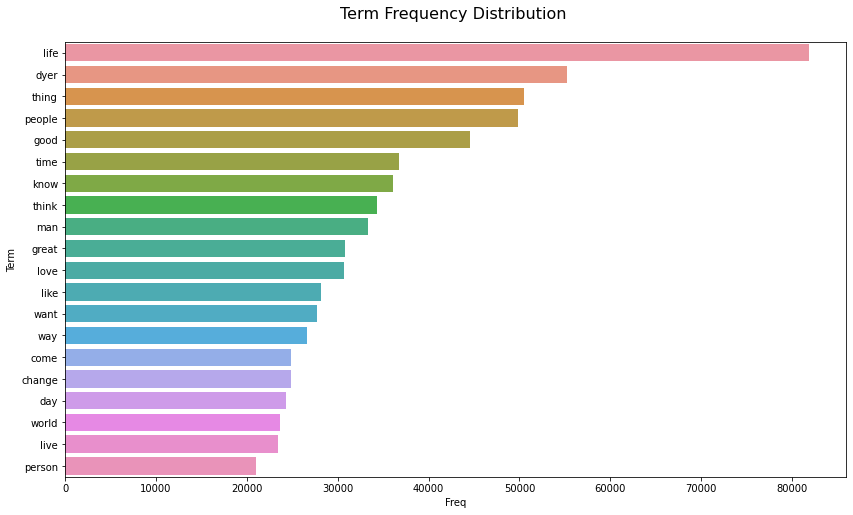

In [67]:
plt.figure(figsize=(14,8))
sns.barplot(data=word_freq.head(20), x='Freq', y='Term')
plt.title('Term Frequency Distribution \n', fontsize=16)
plt.show()

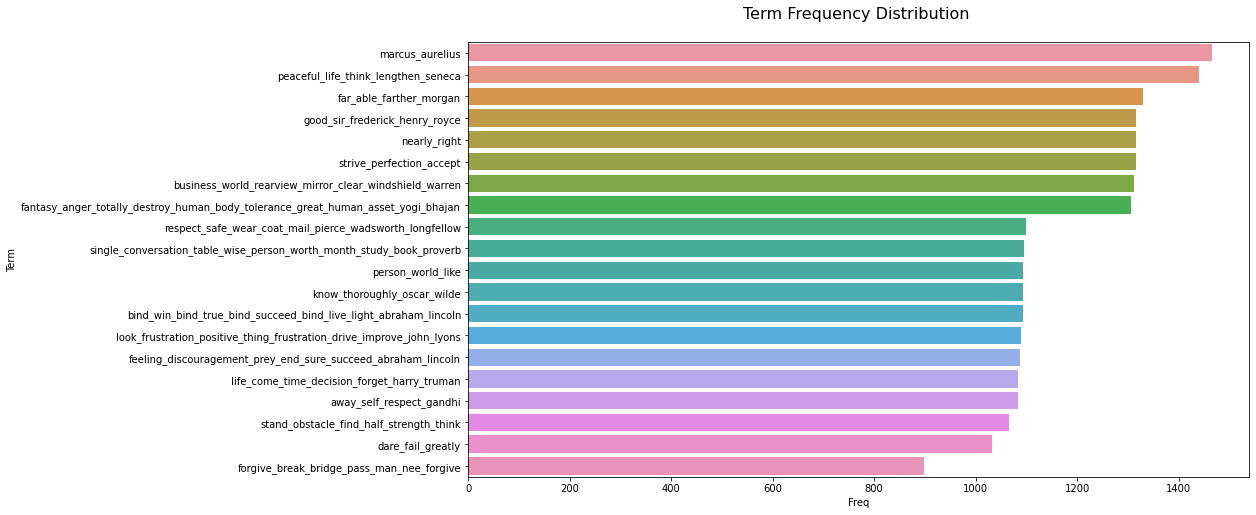

In [68]:
plt.figure(figsize=(14,8))
sns.barplot(data=phrase_freq.head(20), x='Freq', y='Term')
plt.title('Term Frequency Distribution \n', fontsize=16)
plt.show()

In [69]:
mask = np.array(Image.open('/content/drive/MyDrive/Data/NLP_Capstone/word_cloud_background.png'))

In [70]:
def wordcloud(text, colormap='tab10', background_color='white'):
  cloud = WordCloud(width=1600, height=800,
                    mask=None, 
                    stopwords=None, 
                    colormap=colormap, 
                    background_color=background_color).generate_from_frequencies(text)

  plt.figure(figsize=(12,10))
  plt.imshow(cloud)
  plt.axis("off")
  plt.tight_layout(pad=0)
  plt.show()

In [71]:
# wordcloud needs terms and freq into dict form
word_dict = dict(zip(word_freq['Term'],word_freq['Freq']))
phrase_dict = dict(zip(phrase_freq['Term'],phrase_freq['Freq']))

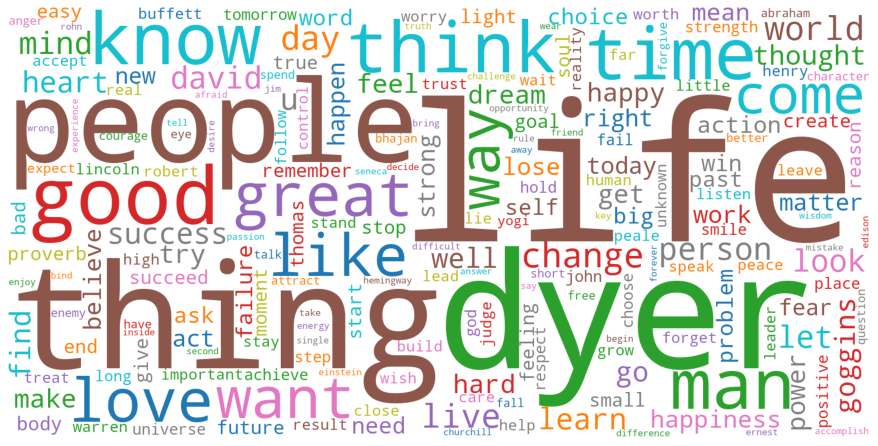

In [72]:
wordcloud(word_dict)

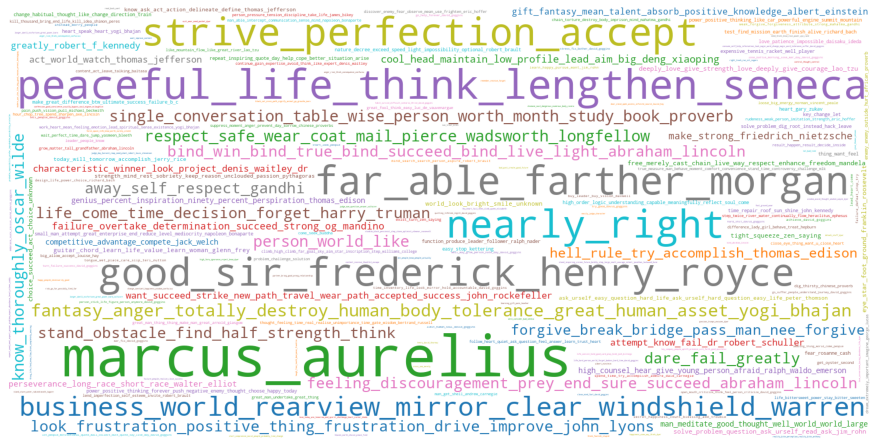

In [73]:
wordcloud(phrase_dict)

In [74]:
# copy ngram dataframe to tweets cleaned
tweets_cleaned = contains_ngram.copy()

Because of csv errors on later imports, we will export our data using json.

In [75]:
# Export dataframe into json
tweets_cleaned.to_json('/content/drive/MyDrive/Data/NLP_Capstone/motivational_tweets_cleaned2.json', orient='columns')

In [76]:
tweets_cleaned.head()

,date,user_name,content,content_preprocessed,unigram_tokens,ngrams,ngram_tokens,nouns_only,nouns_verbs,bigrams_trigrams,bigrams_trigrams_strings
44,2021-01-17 22:13:17,LewisHowes,Know this. Everything is happening for a reason and in your favor for the betterment of your future. The pain you feel now will help later if you: 1. Look at what's not serving you 2. Listen to your intuition 3. Learn the meaning behind it 4. Let go of limits that hold you back,know happen reason favor betterment future pain feel help later look serve listen intuition learn meaning let limit hold,"[know, happen, reason, favor, betterment, future, pain, feel, help, later, look, serve, listen, intuition, learn, meaning, let, limit, hold]",know_happen_reason favor betterment future pain feel help later look serve listen intuition learn meaning let limit hold,"[know_happen_reason, favor, betterment, future, pain, feel, help, later, look, serve, listen, intuition, learn, meaning, let, limit, hold]","[reason, favor, betterment, future, pain, feel, help, intuition, learn, limit]","[know, reason, favor, betterment, future, pain, feel, help, look, serve, intuition, learn, meaning, let, limit, hold]",[know_happen_reason],know_happen_reason
61,2021-01-15 15:28:06,LewisHowes,Protect your inner peace at all costs. Create daily practices and communicate boundaries to make sure the stress and drama of others doesn't consume you. You don't need to be someone else's emotional punching bag. Your energy and happiness is too important. Protect your peace!,protect inner peace cost create daily practice communicate boundary sure stress drama consume need emotional punching bag energy happiness important protect peace,"[protect, inner, peace, cost, create, daily, practice, communicate, boundary, sure, stress, drama, consume, need, emotional, punching, bag, energy, happiness, important, protect, peace]",protect inner_peace cost create daily_practice communicate boundary sure stress drama consume need emotional punching bag energy happiness important protect peace,"[protect, inner_peace, cost, create, daily_practice, communicate, boundary, sure, stress, drama, consume, need, emotional, punching, bag, energy, happiness, important, protect, peace]","[peace, cost, practice, communicate, stress, drama, punching, bag, energy, happiness, protect, peace]","[peace, cost, practice, communicate, stress, drama, punching, bag, energy, happiness, protect, peace]","[inner_peace, daily_practice]",inner_peace daily_practice
161,2021-01-07 16:00:29,LewisHowes,"Always remember to ask for exactly what you want. Ask for love, good health, abundance and peace. Ask for wisdom, creativity and positive energy. Don't be shy in your dreams. Be bold and live in gratitude because everything you want is coming to you.",remember ask exactly want ask love good health abundance peace ask wisdom creativity positive energy shy dream bold live gratitude want come,"[remember, ask, exactly, want, ask, love, good, health, abundance, peace, ask, wisdom, creativity, positive, energy, shy, dream, bold, live, gratitude, want, come]",remember ask exactly want ask love good health_abundance peace ask_wisdom creativity positive energy shy dream bold live gratitude want come,"[remember, ask, exactly, want, ask, love, good, health_abundance, peace, ask_wisdom, creativity, positive, energy, shy, dream, bold, live, gratitude, want, come]","[health, abundance, peace, ask, wisdom, creativity, energy, dream, gratitude, come]","[remember, health, abundance, peace, ask, wisdom, creativity, energy, dream, bold, gratitude, come]","[health_abundance, ask_wisdom]",health_abundance ask_wisdom
274,2021-01-01 02:44:46,LewisHowes,"This will be your greatest year ever. All your work will start to pay off. You will earn more, be happier, love deeper and be healthier. It will all manifest because you built better habits, embraced your fears, added more value to others and took massive action on your goals.",great year work start pay earn h

In [77]:
tweets_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 621264 entries, 44 to 977610
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   date                      621264 non-null  datetime64[ns]
 1   user_name                 621264 non-null  object        
 2   content                   621264 non-null  object        
 3   content_preprocessed      621264 non-null  object        
 4   unigram_tokens            621264 non-null  object        
 5   ngrams                    621264 non-null  object        
 6   ngram_tokens              621264 non-null  object        
 7   nouns_only                621264 non-null  object        
 8   nouns_verbs               621264 non-null  object        
 9   bigrams_trigrams          621264 non-null  object        
 10  bigrams_trigrams_strings  621264 non-null  object        
dtypes: datetime64[ns](1), object(10)
memory usage: 76.9+ MB


In [78]:
tweets_cleaned.shape

(621264, 11)

We have completed our cleaning and feature engineering and our dataframe has been exported to json. Next step is topic modeling. Our modeling notebook can be found [here](https://github.com/tarrantcarter/Final_Capstone/blob/main/Modern_Motivation_Model.ipynb).